In [1]:
%matplotlib inline



import pandas as pd
import requests
import re
import ast
import numpy as np
import seaborn as sns

from collections import defaultdict


In [2]:
ccc_df = pd.read_csv("data/ccc_blm.csv")
ele_df = pd.read_csv("data/ele.csv")
cl_df = pd.read_csv("data/cl_blm.csv")
nyt_df = pd.read_csv("data/nytimes_blm.csv")

wiki_df = pd.read_csv("data/wiki_blm.csv")


dfs = [ccc_df, ele_df, cl_df, wiki_df, nyt_df]

In [3]:
df = pd.concat(dfs).reset_index(drop=True)
display(df)

,id,date,city_st,location,size,size_str,urls,collection,Unnamed: 0
0,NaN,2020-05-26,"Houston, TX","Discovery Green, Houston, TX",NaN,NaN,['https://www.houstonchronicle.com/news/housto...,CCC,NaN
1,NaN,2020-05-26,"Minneapolis, MN",site of Floyd's arrest; Minneapolis Police Dep...,2000.0,several thousand,['https://www.startribune.com/restraint-needed...,CCC,NaN
2,NaN,2020-05-26,"Minneapolis, MN","outside third precinct, Minneapolis, MN",200.0,several hundred,['https://twitter.com/StarTribune/status/12654...,CCC,NaN
3,NaN,2020-05-26,"St. Paul, MN","near home of Derek Chauvin, St. Paul, MN",NaN,NaN,['https://www.cbsnews.com/news/george-floyd-de...,CCC,NaN
4,NaN,2020-05-26,"Suffolk, VA","North Suffolk Police Station, Suffolk, VA",2.0,count pic,['https://www.suffolknewsherald.com/2020/05/27...,CCC,NaN
...,...,...,...,...,...,...,...,...,...
8346,NaN,06/08/2020,"Tupper Lake, NY",NaN,NaN,NaN,['https://www.adirondackdailyenterprise.com/ne...,New York Times,NaN
8347,NaN,06/08/2020,"Delmar, NY",NaN,NaN,NaN,['https://www.timesunion.com/news/article/Rall...,New York Times,NaN
8348,NaN,06/08/2020,"Clifton Park, NY",NaN,NaN,NaN,['https://cbs6albany.com/news/local/high-schoo...,New York Times,NaN
8349,NaN,06/08/2020,"Claremont, NH",NaN,NaN,NaN,['https://www.youtube.com/watch?v=gR8IeATEUzY'],New York Times,NaN


In [4]:
df['collection'].value_counts()

New York Times    2633
Count Love        2173
CCC               1822
Wikipedia          943
Elephrame          780
Name: collection, dtype: int64

In [5]:
date_start = pd.to_datetime('2020-05-25')
df = df[pd.to_datetime(df['date']) > date_start].copy()
df = df[pd.to_datetime(df['date']) <= pd.Timestamp.today()].copy()


In [6]:
df['date'] = pd.to_datetime(df['date']).dt.date
df['date'].value_counts()

2020-05-31    1319
2020-05-30    1117
2020-06-01     823
2020-06-06     728
2020-06-02     702
2020-06-03     592
2020-06-05     532
2020-06-07     470
2020-06-04     436
2020-05-29     383
2020-06-08     140
2020-05-28     137
2020-06-12      84
2020-06-09      78
2020-06-10      54
2020-06-13      43
2020-05-27      32
2020-06-11      31
2020-05-26      19
Name: date, dtype: int64

In [7]:
# fix stay commas

df['city_st'] = df['city_st'].str.replace(' , ', ', ')
df['city_st'] = df['city_st'].str.strip()


len(df)

7720

In [8]:
# eliminate non US events

countries = [
    "Finland",
    "England",
    "Wales",
    "Canada",
    "Scotland", 'Sweden', 'Ottowa'
    "Germany", "Netherlands"
    "Ireland", 'Sweden'
    "Netherlands",
    "New Zealand",
    "Denmark",
    "Australia",
    "Belgium", "Uganda", 'Croatia'
    "France", 'Hungary',
]


def in_us(city_st):
    for c in countries:
        c2 = ", " + c
        if c2 in city_st:
            print(c2)
            return False

    return True


df = df[df["city_st"].apply(in_us)].copy()
len(df)

, England
, Canada
, Uganda
, England
, England
, England
, England
, England
, Canada
, Belgium
, Hungary
, Australia
, England
, England
, England
, Scotland
, Scotland
, Canada
, Canada
, England
, Canada
, England
, England
, Canada
, Australia
, Canada
, England
, England
, Finland
, Canada
, Canada
, Sweden
, England
, Canada
, Canada
, New Zealand
, New Zealand
, Canada
, New Zealand
, New Zealand
, Canada
, Wales
, Canada
, Denmark
, England
, England
, England


7673

In [9]:
errors = {'Albuqeurque, NM' : 'Albuquerque, NM',
         'Bilings, MT' : 'Billings, MT',
         'Breckinridge, CO' : 'Breckinridge, CO',
          "Longbranch, NJ" : "Long Branch, NJ",
          'Lousiville, KY' : 'Louisville, KY',
          'Merrick, New York' : 'Merrick, NY',
          'Pittsfield Charter Township, MI' : 'Pittsfield, MI',
          'Pittsfield Township, MI' : 'Pittsfield, MI',
          'Phillipsburg, PA' : 'Philipsburg, PA',
          'South Sacramento, CA' :  'Sacramento, CA',
          'Shelbourne Falls, MA' : 'Shelburne Falls, MA',
          'Tallahasee, FL' : 'Tallahassee, FL',
          'Tampa Bay, FL' : "Tampa, Fl",
          'Voorhees Township, NJ' : 'Voorhees, NJ',
          'Warren Township, NJ' : 'Warren, NJ', 
          'Summerlin, NV' : 'Las Vegas, NV',
          'Stockton, TX' : 'Fort Stockton, TX',
          'Standford, CA' : 'Stanford, CA',
        
          
         }

for city in errors:
    df['city_st'] = df['city_st'].str.replace(city, errors[city])

In [10]:
#uniform saint to st
df['city_st'] = df['city_st'].str.replace('Saint ', 'St. ')

In [11]:
df['events'] = 1
df['size'] = df['size'].replace(0,np.nan)
df['size_imp'] = df['size'].fillna(11)


df = pd.concat([df, pd.get_dummies(df['collection'])], axis=1)

In [12]:
# extract urls to make them variables

def str_2_list(links):
    return ast.literal_eval(links)

df['url_list'] = df['urls'].apply(str_2_list)


urls = set([item for sublist in df['url_list'].values for item in sublist])

for url in urls:
    df[url] = df['urls'].str.contains(url)

/Users/nealcaren/opt/anaconda3/envs/tmwp/lib/python3.8/site-packages/pandas/core/strings.py:1954: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


First Pass at Aggregation

In [13]:
df['size'] = df['size'].replace('hundreds', 200).astype(float)

In [14]:
# first sum by collection for multiple events by city
df_cd = df.groupby(['collection', 'date', 'city_st']).sum().reset_index()

In [15]:
df_cd['size_imp'] = df_cd['size'].fillna(11)

In [16]:
for v in ["CCC", 
    "Count Love", 
    "Elephrame",
         "Wikipedia",
         "New York Times"]:
    df_cd[v] = df_cd[v] > 0
    df_cd[v] = df_cd[v].astype(int)

In [17]:

aggregation = {
    "events": "max",
    "size": "max",
    "size_imp" : "max",
    "CCC" : "max",
    "Wikipedia" : "max",
    "Count Love" : "max",
    "Elephrame" : "max",
    "New York Times": "max"
}


for url in urls:
    aggregation[url] = 'max'

df_cd = df_cd.groupby(["date", "city_st"]).agg(aggregation).reset_index()

In [18]:
# Create list of URLs

index_dict = defaultdict(list)

http_urls = [u for u in df_cd.keys() if 'http' in u]

for url in http_urls:
    for i in df_cd[df_cd[url] == True].index.values:
        index_dict[i].append(url)

url_df = pd.Series(index_dict).to_frame(name='urls')



In [19]:
keep = [
    "date",
    "city_st",
    "events",
    "size",
    "size_imp",
    "CCC",
    "Count Love",
    "Elephrame",
    "New York Times",
    "Wikipedia"

]

In [20]:
df_cd = df_cd[keep].merge(url_df, left_index=True, right_index=True)

In [21]:
df_cd['size'] = df_cd['size'].replace(0, np.nan)
df_cd['size_imp'] = df_cd['size'].replace(0, np.nan)
df_cd['size_imp'] = df_cd['size'].fillna(11)

In [22]:


df_cd.to_csv('../BLM-GFAABT.csv', index =False)




In [34]:
temp = df_cd.groupby(['date','city_st']).agg({'events': 'count',
                                            'Elephrame' : 'max',
                                            'CCC': 'max',
                                            'Count Love': 'max',
                                              "New York Times" : 'max',
                                             'Wikipedia' : 'max'}).reset_index()

temp['cities'] = temp['events']
print(temp.groupby('date')[['cities','Elephrame','CCC','Count Love', 'New York Times', 'Wikipedia']].sum().to_markdown())

| date       |   cities |   Elephrame |   CCC |   Count Love |   New York Times |   Wikipedia |
|:-----------|---------:|------------:|------:|-------------:|-----------------:|------------:|
| 2020-05-26 |       11 |           1 |     4 |            7 |                6 |           0 |
| 2020-05-27 |       19 |           0 |    10 |           11 |               11 |           0 |
| 2020-05-28 |       63 |           0 |    36 |           41 |               41 |          11 |
| 2020-05-29 |      179 |           1 |   105 |          124 |               94 |          41 |
| 2020-05-30 |      464 |          67 |   187 |          311 |              337 |         154 |
| 2020-05-31 |      656 |          90 |   192 |          365 |              460 |         168 |
| 2020-06-01 |      506 |          44 |   139 |          176 |              330 |         101 |
| 2020-06-02 |      457 |          39 |   158 |          101 |              296 |          62 |
| 2020-06-03 |      381 |          67 | 

In [24]:
display("Cities:", len(df_cd['city_st'].value_counts()))

'Cities:'

2494

In [25]:
print(df_cd.groupby('date')['events'].sum().to_markdown())

| date       |   events |
|:-----------|---------:|
| 2020-05-26 |       12 |
| 2020-05-27 |       19 |
| 2020-05-28 |       70 |
| 2020-05-29 |      195 |
| 2020-05-30 |      512 |
| 2020-05-31 |      685 |
| 2020-06-01 |      528 |
| 2020-06-02 |      489 |
| 2020-06-03 |      406 |
| 2020-06-04 |      329 |
| 2020-06-05 |      372 |
| 2020-06-06 |      512 |
| 2020-06-07 |      345 |
| 2020-06-08 |      112 |
| 2020-06-09 |       65 |
| 2020-06-10 |       48 |
| 2020-06-11 |       29 |
| 2020-06-12 |       78 |
| 2020-06-13 |       36 |


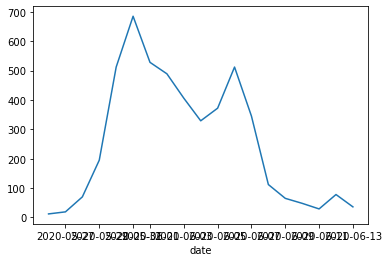

In [26]:
df_cd.groupby('date')['events'].sum().plot();

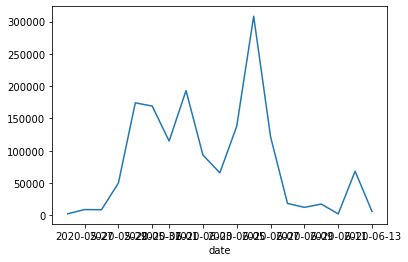

In [27]:
df_cd.groupby('date')['size_imp'].sum().plot();

In [28]:
df_cd['size_imp'].count()

4417

In [29]:
display('Events:',df_cd['events'].sum())

'Events:'

4842

In [30]:
display("Size:",df_cd['size_imp'].sum())

'Size:'

1571829.2

In [31]:


df_cd['size'].describe()

count     2141.000000
mean       722.462961
std       3429.992104
min          1.000000
25%        100.000000
50%        200.000000
75%        400.000000
max      95500.000000
Name: size, dtype: float64

In [32]:
display(df_cd.groupby(["CCC", "Count Love", 'Elephrame','New York Times','Wikipedia'])['events'].count().reset_index())

,CCC,Count Love,Elephrame,New York Times,Wikipedia,events
0,0,0,0,0,1,177
1,0,0,0,1,0,1252
2,0,0,0,1,1,189
3,0,0,1,0,0,227
4,0,0,1,0,1,2
5,0,0,1,1,0,57
6,0,0,1,1,1,15
7,0,1,0,0,0,508
8,0,1,0,0,1,24
9,0,1,0,1,0,326


In [33]:
df_cd['city_st'].value_counts().to_frame().reset_index().sort_values(by='index').to_csv('cities.csv')